In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import mne
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mne.preprocessing import ICA
from mne.decoding import CSP
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from dataset import EEGDataset
import filter as filter
from mlp import TorchDataset, MLP
from plot import plot_eeg, plot_scatter_trials
from sklearn.metrics import classification_report
from metrics import plot_confusion_matrix, plot_roc
from model import train_test_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
import numpy as np
from sklearn.decomposition import FastICA
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split




In [2]:
# Hyper parameters
apply_pca = True
feature_extraction_method = 'ICA'   # 'ICA' or 'CSP'
apply_normalization = False

# Read Dataset

In [3]:
file_path_1 = "../BCICIV_1_mat/BCICIV_calib_ds1a"
data = EEGDataset(file_path_1, start_window=0.5, end_window=3)

# Preprocessing

## Filters

In [4]:
laplacin_filtered = filter.large_laplacian_filter(data)
bandpass_filterd = filter.bandpass_filter(laplacin_filtered,  l_freq=8, h_freq=40)

Setting up band-pass filter from 8 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 11800 out of 11800 | elapsed:    1.9s finished


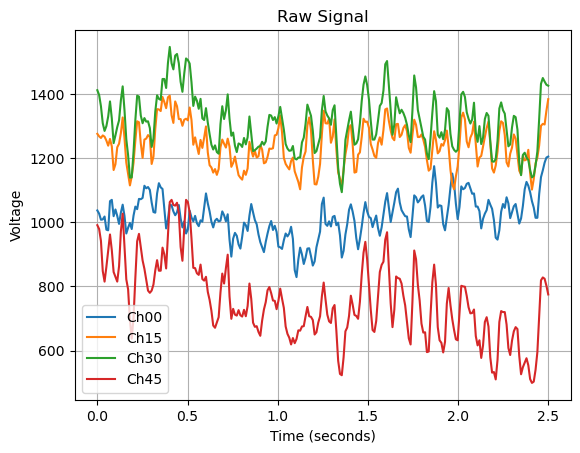

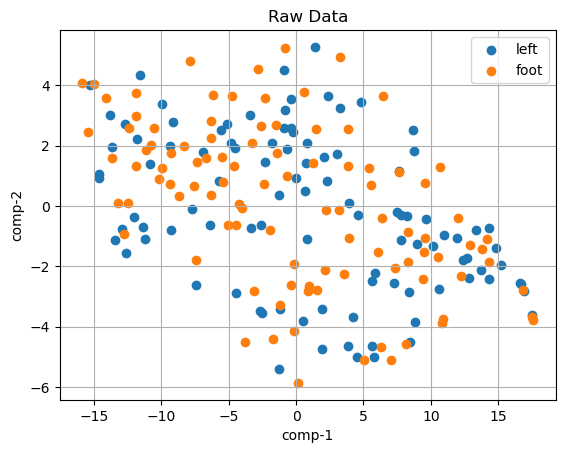

In [5]:
plot_eeg(data, 0, 'Raw Signal')
plt.savefig('../assets/preprocess_raw.png')
plt.show()
plot_scatter_trials(data.trials, data.targets, data.class_labels, 'Raw Data')
plt.savefig('../assets/visual_raw_data.png')

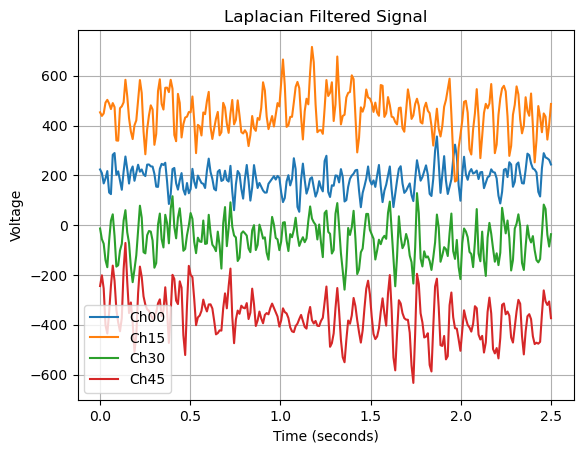

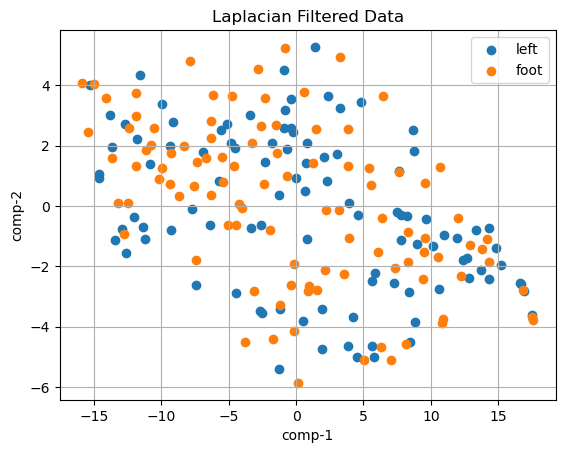

In [6]:
plot_eeg(laplacin_filtered, 0, 'Laplacian Filtered Signal')
plt.savefig('../assets/preprocess_laplacian.png')
plt.show()
plot_scatter_trials(data.trials, data.targets, data.class_labels, 'Laplacian Filtered Data')
plt.savefig('../assets/visual_laplacian_data.png')

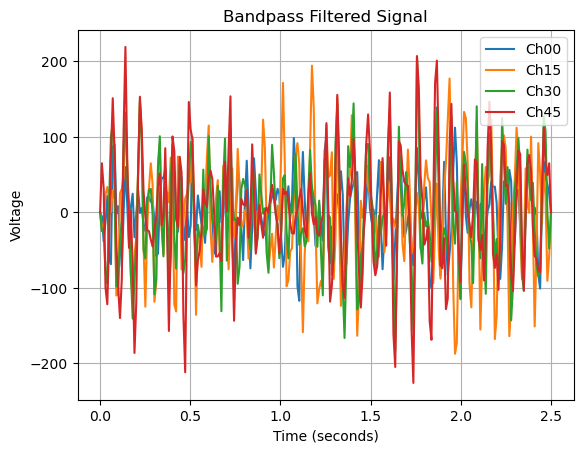

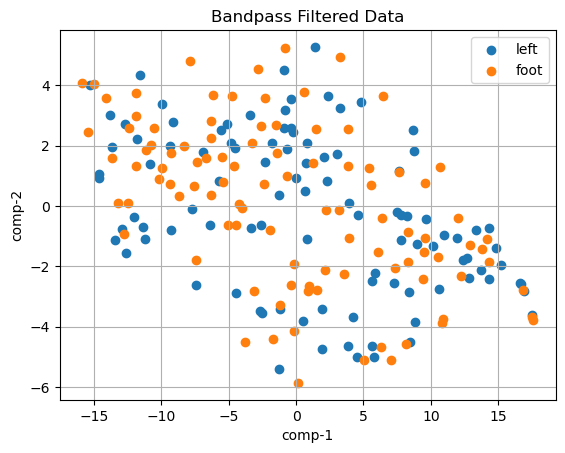

In [7]:
plot_eeg(bandpass_filterd, 0, 'Bandpass Filtered Signal')
plt.savefig('../assets/preprocess_bandpass.png')
plt.show()
plot_scatter_trials(data.trials, data.targets, data.class_labels, 'Bandpass Filtered Data')
plt.savefig('../assets/visual_laplacian_data.png')

In [8]:
data = bandpass_filterd

## Train Test Split

In [9]:
X = data.trials
y = data.targets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=40,
    stratify=y
)

In [10]:
# Hyper parameters
apply_pca = False
feature_extraction_method = 'CSP'   # 'ICA' or 'CSP'
apply_normalization = False

## PCA

In [596]:
pca = PCA(n_components=X_train.shape[0])
X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))

In [597]:
if apply_pca:
    X_train = X_train_pca.reshape(X_train.shape[0], X_train.shape[0] // 2, 2)
    X_test = X_test_pca.reshape(X_test.shape[0], X_train.shape[0] // 2, 2)

## ICA

In [598]:
ica = FastICA(n_components=59,
              random_state=42)

X_train_ica = ica.fit_transform(X_train.reshape(X_train.shape[0], -1), y_train)

X_test_ica = ica.transform(X_test.reshape(X_test.shape[0], -1))


## CSP

In [11]:
csp = CSP(n_components=59, reg=None, log=None, norm_trace=False)
X_train_csp = csp.fit_transform(X_train, y_train)
X_test_csp = csp.transform(X_test)

Computing rank from data with rank=None
    Using tolerance 1.5e+03 (2.2e-16 eps * 59 dim * 1.1e+17  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


In [12]:
if feature_extraction_method == 'ICA':
    X_train = X_train_ica
    X_test = X_test_ica
else:
    X_train = X_train_csp
    X_test = X_test_csp

In [601]:
def normalize(X):
    X_mean = np.mean(X, axis=0)
    X_std_dev = np.std(X, axis=0)
    X_normalized = (X - X_mean) / X_std_dev
    return X_normalized

if apply_normalization:
    X_train = normalize(X_train)
    X_test = normalize(X_test)

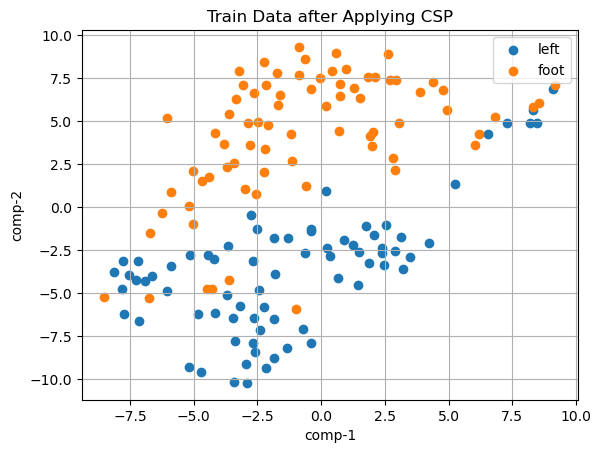

In [13]:
plot_scatter_trials(X_train, y_train, data.class_labels, 'Train Data after Applying CSP')
plt.savefig('../assets/train_data_csp.png')

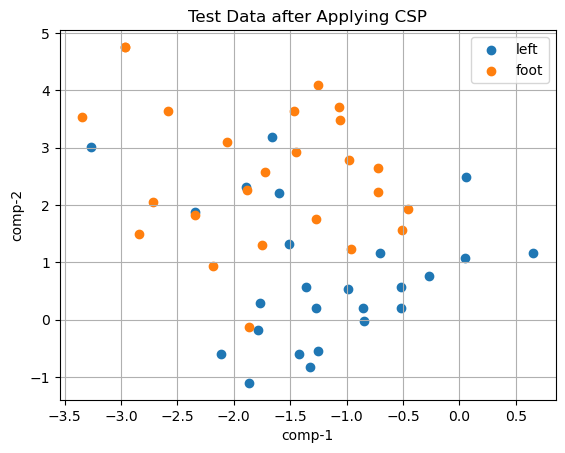

In [14]:
plot_scatter_trials(X_test, y_test, data.class_labels, 'Test Data after Applying CSP')
plt.savefig('../assets/test_data_csp.png')  

## Logistic Regression

              precision    recall  f1-score   support

        left       0.89      0.96      0.92        25
        foot       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



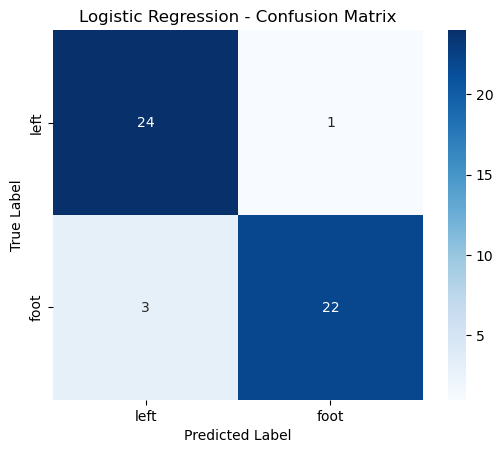

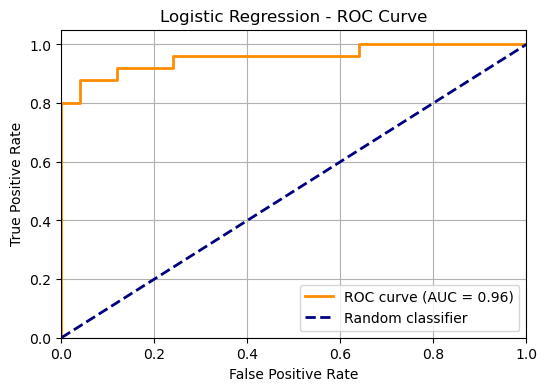

In [15]:
model = LogisticRegression(max_iter=300)
train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'Logistic Regression')

## SVM

              precision    recall  f1-score   support

        left       0.89      0.96      0.92        25
        foot       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



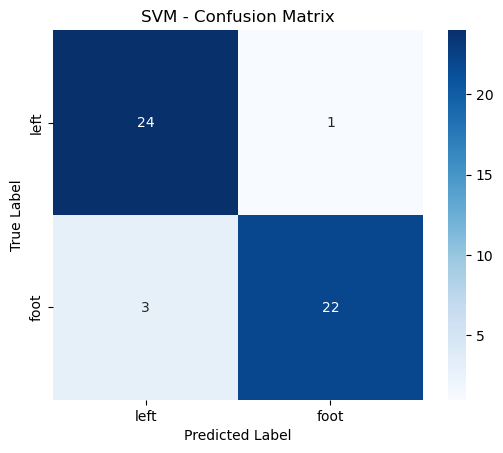

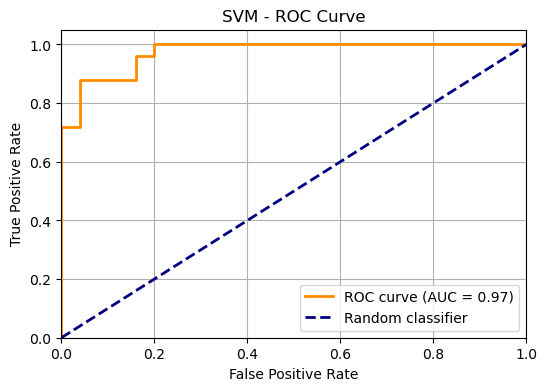

In [16]:
model = SVC(kernel='rbf', C=1, probability=True)
train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'SVM')

## KNN

              precision    recall  f1-score   support

        left       0.79      0.92      0.85        25
        foot       0.90      0.76      0.83        25

    accuracy                           0.84        50
   macro avg       0.85      0.84      0.84        50
weighted avg       0.85      0.84      0.84        50



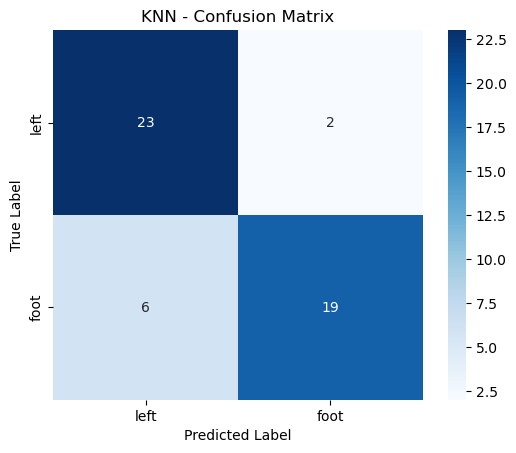

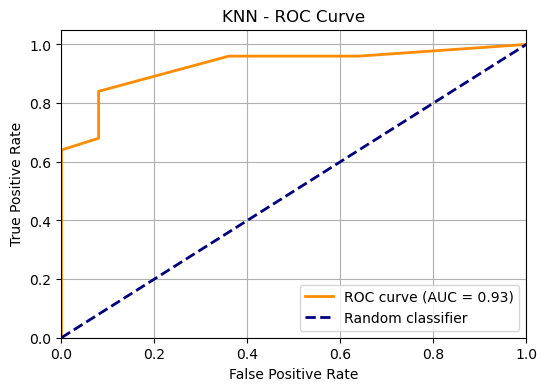

In [17]:
model = KNeighborsClassifier(n_neighbors=7)
train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'KNN')

## MLP

Epoch [50/400], Loss: 0.5509
Epoch [100/400], Loss: 0.4810
Epoch [150/400], Loss: 0.4078
Epoch [200/400], Loss: 0.3723
Epoch [250/400], Loss: 0.3744
Epoch [300/400], Loss: 0.3513
Epoch [350/400], Loss: 0.3542
Epoch [400/400], Loss: 0.3368

              precision    recall  f1-score   support

        left       0.85      0.88      0.86        25
        foot       0.88      0.84      0.86        25

    accuracy                           0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.86      0.86      0.86        50



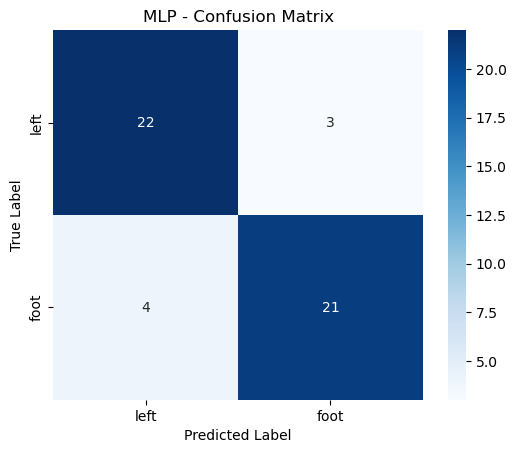

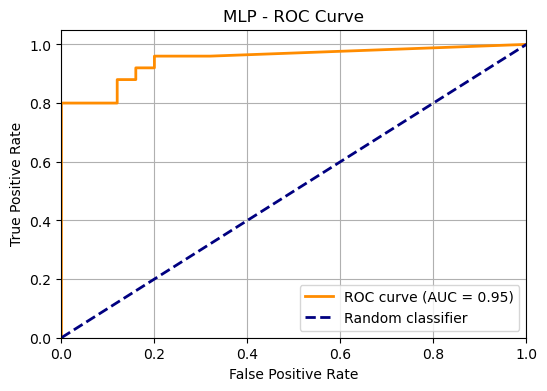

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP(input_shape=(-1, 59),
            num_classes=2, 
            batch_size=64,
            lr=0.001,
            num_epochs=400, 
            device=device
        ).to(device)

train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'MLP')

## AdaBoost

              precision    recall  f1-score   support

        left       0.89      0.96      0.92        25
        foot       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



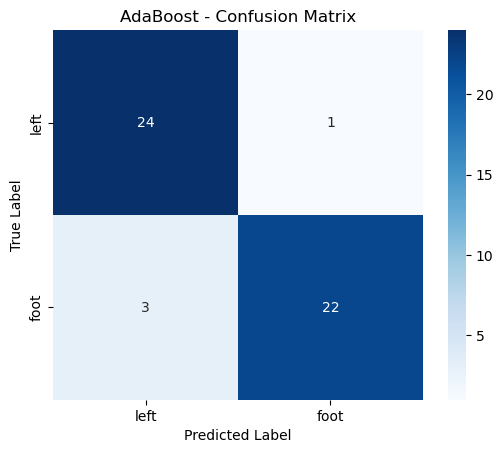

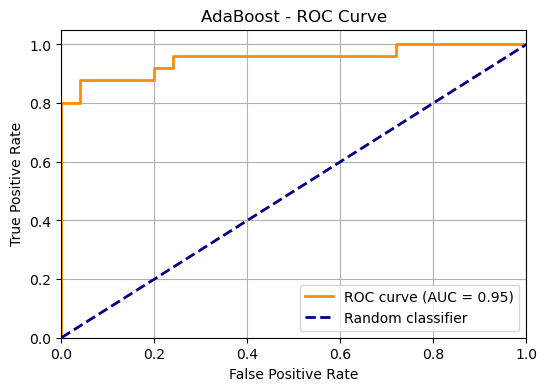

In [19]:
estimator = LogisticRegression(max_iter=300, C=10)
model = AdaBoostClassifier(
    estimator=estimator, 
    n_estimators=10, 
    random_state=42)

train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'AdaBoost')

## XGBoost

              precision    recall  f1-score   support

        left       0.89      1.00      0.94        25
        foot       1.00      0.88      0.94        25

    accuracy                           0.94        50
   macro avg       0.95      0.94      0.94        50
weighted avg       0.95      0.94      0.94        50



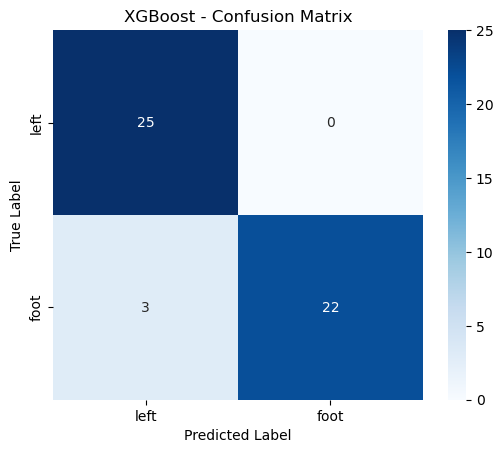

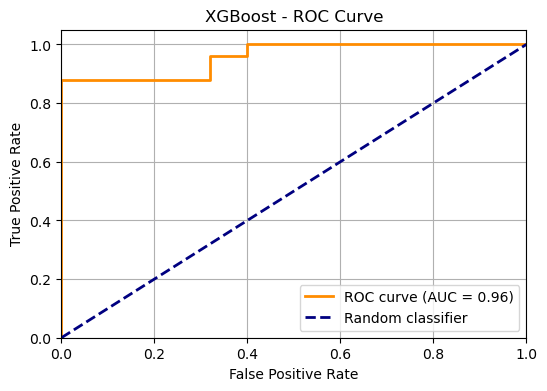

In [20]:
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=2,
    max_depth=1,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42,
    reg_alpha=2,  
)

train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'XGBoost')

# Clustering

/home/mehdi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


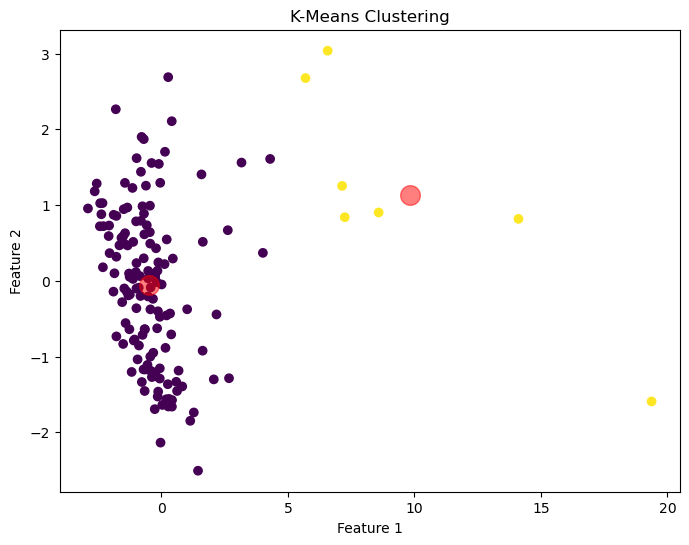

In [256]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_csp)

labels = kmeans.labels_

# Get cluster centroids


pca = PCA(n_components=2)
X = pca.fit_transform(X_train_csp)
centroids = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5)
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [258]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score
print("silhouette: ", silhouette_score(X_train_csp, labels))
print("homegenity: ", homogeneity_score(y_train, labels))


silhouette:  0.7109215066652862
homegenity:  0.0007229831808636991


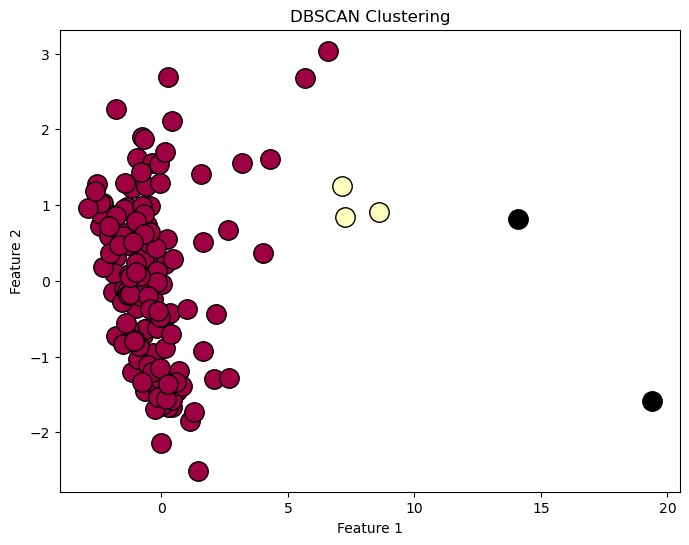

In [253]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=3, min_samples=2)
labels = dbscan.fit_predict(X_train_csp)

pca = PCA(n_components=2)
X = pca.fit_transform(X_train_csp)

unique_labels = set(labels)

# Plot the results
plt.figure(figsize=(8, 6))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for label, color in zip(unique_labels, colors):
    if label == -1:
        # Black used for noise points
        color = [0, 0, 0, 1]

    class_member_mask = (labels == label)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(color),
             markeredgecolor='k', markersize=14)

plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [255]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score
print("silhouette: ", silhouette_score(X_train_csp, labels))
print("homegenity: ", homogeneity_score(y_train, labels))


silhouette:  0.6250485623876524
homegenity:  0.0016672489850587998
